# 1. Architecture at a Glance

nuX is structured into **modular thorns**, each handling a specific layer of the neutrino transport problem.  

---

### Thorns
- **nuX_M1**  
  Core transport: evolves radiation moments, computes closures, fluxes, geometric sources, stiff local updates, and couples neutrino radiation to the fluid.

- **nuX_Rates**  
  Provides weak interaction rates via `bns_nurates` library: emissivities (η), absorption opacities (κ_abs), and scattering opacities (κ_scat).  
  Implements β-processes, pair processes, nucleon scattering, etc.

- **nuX_Utils**  
  Utility layer: metric/geometry helpers, tensor algebra, index management, centering (cell vs face), Valencia formulation helpers.

- **nuX_Seeds**  
  Provides initial data: `rE`, `rF`, `rN` as well as all MHD variables for standard tests

- **nuX_FakeRates** (optional)  
  Supplies deterministic toy rates for debugging the transport without full microphysics.

---

### Couplings & Inputs
- **Geometry:** from `ADMBaseX`  
  Provides lapse (α), shift (β^i), spatial metric (γ_ij), extrinsic curvature (K_ij).

- **Fluid:** from `AsterX/HydroBaseX`  
  Provides density (ρ), velocity (v^i), pressure (p), specific energy (ε), and electron fraction (Y_e).

- **EOS:** via `EOSX` + `nuX_Rates`  
  Thermodynamics from EOS tables, microphysics from rates.

---

### Evolved Radiation Fields
- **Lab frame:**  
  - `rE` (energy density)  
  - `rF` (flux vector)  
  - `rN` (number density, per species×energy group)

- **Fluid frame:**  
  - `rJ` (comoving energy)  
  - `rH` (comoving flux)  
  - `rP` (pressure tensor from closure)  
  - `chi` (Eddington factor)

- **Per-face packed fluxes:**  
  `nu_flux_x, nu_flux_y, nu_flux_z` (holding 5 components/species/group)


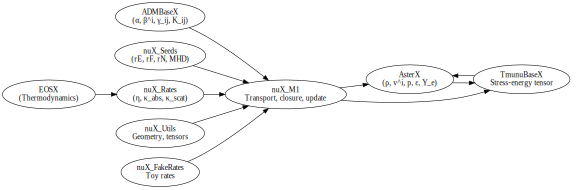

In [7]:
# Optional diagram: Thorn interactions
from graphviz import Digraph

dot = Digraph(comment="nuX Architecture")
dot.attr(rankdir="LR", size="8")

dot.node("ADM", "ADMBaseX\n(α, β^i, γ_ij, K_ij)")
dot.node("Hydro", "AsterX\n(ρ, v^i, p, ε, Y_e)")
dot.node("EOS", "EOSX\n(Thermodynamics)")
dot.node("ID", "nuX_Seeds\n(rE, rF, rN, MHD)")
dot.node("Rates", "nuX_Rates\n(η, κ_abs, κ_scat)")
dot.node("M1", "nuX_M1\nTransport, closure, update")
dot.node("Utils", "nuX_Utils\nGeometry, tensors")
dot.node("Fake", "nuX_FakeRates\nToy rates")
dot.node("Tmunu", "TmunuBaseX\nStress-energy tensor")

dot.edges([("ADM","M1"), ("EOS","Rates"), ("Rates","M1"), ("ID", "M1"), ("M1","Hydro"),
           ("Utils","M1"), ("Fake","M1"), ("M1","Tmunu"), ("Hydro","Tmunu"), ("Tmunu","Hydro")])

dot


# 2. Scheduling & Global Flow

nuX_M1 is driven by the Cactus scheduling system. Each function is tied to a *schedule group* that determines
when and how it is invoked during the simulation lifecycle.

---

## Startup & Parameter Checks

- **`nuX_M1_Init`** (CCTK_STARTUP)  
  - Registers the thorn banner.  
  - Allocates module-level storage and initializes flags.

- **`nuX_M1_ParamCheck`** (CCTK_PARAMCHECK)  
  - Validates parameter settings (ghost zones, closure options, limiter stencils, etc.).  
  - Ensures numerical stability requirements (e.g., at least two ghost zones for flux reconstruction).

---

## Initial Data Setup (CCTK_INITIAL, inside ODESolvers_Initial)

1. **`nuX_M1_InitVolform`**  
   - Precomputes geometric weights and the volume form (`volform`).  
   - Required for integrating contributions to T^{μν} and for diagnostics.

2. **`nuX_M1_Reset`**  
   - Zeros out radiation fields (`rN, rE, rF`).  
   - Resets masks (`nuX_m1_mask`) that mark excision or inactive zones.

3. **`nuX_M1_FiducialVelocity`**  
   - Builds the fiducial 4-velocity and Lorentz factor (w_lorentz).  
   - “Mixed” option smoothly damps the velocity to zero in atmosphere regions, preventing closure pathologies.  
   - Writes `fidu_vel{xyz}` and `fidu_w_lorentz`.

4. **`nuX_M1_CalcClosure`**  
   - From `rE, rF` and the fiducial velocity:  
     - Computes comoving moments (`rJ, rH`).  
     - Builds the pressure tensor (`rP`) using chosen closure.  
     - Computes the Eddington factor (`chi`).  
     - Derives `rnnu = rN/Γ` with Γ from the transformation.

5. **`nuX_M1_CopyLevels`**  
   - Synchronizes data across AMR levels.  
   - Maintains consistency after initialization or checkpoint restart.

---

## Evolution Wrapper

- **Control:** `CCTK_EVOL` → `nuX_M1_WRAP` → `nuX_M1_EVOL`  
- **Integrator:** Two-stage SSPRK scheme.  
- **Key idea:** Explicit update for advection/geometry, semi-implicit solve for stiff microphysics.

---

### Sub-Stage Workflow (TimeIntegratorStage = 2 → 1 → 0)

1. **`nuX_M1_InitTimeIntegrator`**  
   - Initializes stage counters.  
   - Caches the original time.  
   - Computes Δt for the stage.

2. **`nuX_M1_SetMask`**  
   - Updates the mask (`nuX_m1_mask`) to exclude excision regions or enforce atmosphere zones.

3. **`nuX_M1_InitFluxesRHS`**  
   - Zeros out RHS arrays (`rN_rhs, rE_rhs, rF_rhs`).  
   - Clears face flux buffers (`nu_flux_x|y|z`).

4. **`nuX_M1_FiducialVelocity`** (again)  
   - Rebuilds fiducial velocity to keep in sync with updated hydro fields.

5. **`nuX_M1_CalcOpacity`**  
   - Calls into `nuX_Rates/m1_opacities.hpp`.  
   - Computes emissivity (η), absorption (κ_abs), scattering (κ_scat) for each species × group.  
   - Stores results in `opacs`.  
   - If `use_fakerates`, uses deterministic test values instead.

6. **`nuX_M1_CalcClosure`**  
   - Refreshes closure quantities (`rJ, rH, rP, chi, rnnu`).  
   - Ensures that subsequent updates use the latest (E,F).

7. **Explicit Transport**  
   - **`nuX_M1_CalcFluxes`**  
     - For each direction, reconstructs L/R states of `{rN, rF_x, rF_y, rF_z, rE}`.  
     - Applies minmod limiter.  
     - Combines with LF flux splitting.  
     - Produces face-centered fluxes (`nu_flux_x|y|z`).  
   - **`nuX_M1_UpdateRHSFromFluxes`**  
     - Computes cell-centered divergence of fluxes.  
     - Accumulates into RHS arrays.

8. **Curved-Spacetime Source Terms**  
   - **`nuX_M1_CalcGRSources`**  
     - Samples metric derivatives.
     - Computes contributions from Christoffel symbols and extrinsic curvature.  
     - Adds GR source terms to RHS.  
     - Implements the 3+1 conservative form of ∇·T^{μν}.

9. **Stiff Local Matter–Radiation Coupling**  
   - **`nuX_M1_CalcUpdate`**  
     - Forms comoving estimates (E*, F*).  
     - Gathers opacities (η, κ_abs, κ_scat).  
     - Constructs unknown vector q = (E, Fx, Fy, Fz).  
     - Solves nonlinear system via Newton–Raphson (`newton_raphson_nd`).  
       - Analytic Jacobian from `nuX_M1_sources.hxx`.  
       - Floors (`rad_E_floor`) prevent negative energy.  
       - Falls back to Eddington closure if Newton-Raphson fails in optically thick regime.  
       - Separate linearizations for thin vs thick regimes.  
     - Updates:  
       - `rE, rF` (radiation fields).  
       - AsterX `fluidsources` (backreaction energy/momentum).  
       - Ye updates.  
       - Refreshes closure (`chi`).  

10. **`nuX_M1_UpdateTime`**  
    - Advances stage time.  
    - Temporarily shifts cctk_time to ensure SSPRK consistency.

11. **`nuX_M1_BoundaryConditions`**  
    - Placeholder; relies on driver prolongation and sync.  
    - Respects READS/WRITES annotations (“interior” vs “everywhere”).

---

## Stress–Energy Accumulation (T^{μν})

- If `add_to_Tmunu = yes`:  
  - `nuX_M1_FiducialVelocity`: ensures correct frame.  
  - `nuX_M1_AddToTmunu`: constructs T^{μν} from (E,F,P).  
  - Adds contributions to `TmunuBaseX::eTtt, eTti, eTij`.  
  - Ensures neutrinos contribute to gravity consistently.

---

## Analysis Hooks

- **`nuX_M1_CalcClosure` + `nuX_M1_Analysis`**  
  - Produces diagnostic fields (e.g., chi maps).  
- **`nuX_M1_CalcRadialFluxes`**  
  - Integrates radial fluxes across spherical shells.  
  - Provides luminosity diagnostics for each neutrino species/group.


# 3. Physics ↔ Implementation

Here we map the governing two-moment M1 equations directly onto code components.

---

## Two-Moment M1 System

- **Evolved (lab frame):**  
  - Energy density (E → `rE`)  
  - Flux vector (F^i → `rF`)  
  - Number density (N → `rN`)  

- **Comoving (fluid frame):**  
  - Energy (J → `rJ`)  
  - Flux (H^i → `rH`)  
  - Pressure tensor (P^{ij} → `rP`)  
  - Eddington factor (χ → `chi`)  

- **Code location:** `nuX_M1_CalcClosure`.

---

## Closure

- Default: **M1 closure** χ(f) with f = |F|/E.  
- Provides smooth transition from diffusion to free-streaming.  
- Fallback: **Eddington limit** used in stiff solver if Newton struggles in thick cells.  
- **Implementation:** `nuX_M1_closure.hxx`.  

---

## Advection / Transport (Hyperbolic part)

- **`nuX_M1_CalcFluxes`**  
  - Reconstructs variables at faces with minmod limiter.  
  - Computes numerical flux using LF splitting.  
  - Geometry sampled at cell centers, face-averaged.  
  - Produces face flux arrays (`nu_flux_x|y|z`).  

- **`nuX_M1_UpdateRHSFromFluxes`**  
  - Takes discrete divergence of face fluxes.  
  - Populates RHS arrays (`r*_rhs`).  

---

## Curved-Spacetime Terms

- **`nuX_M1_CalcGRSources`**  
  - Evaluates ∂_i α, Γ^i_{jk}, K_ij.  
  - Adds curvature terms to RHS.  
  - Implements ∇_μ T^{μν} in 3+1 form.  

---

## Microphysics

- **`nuX_M1_CalcOpacity`**  
  - Calls into `nuX_Rates/m1_opacities.hpp`.  
  - Computes emissivity (η), absorption (κ_abs), scattering (κ_scat).  
  - Driven by EOS state (ρ, T, Y_e).  

- **Consistency with physics:** For source terms S^μ = (emission − absorption − scattering) in comoving frame, then transformed back.

---

## Stiff Coupling / Semi-Implicit Solve

- **`nuX_M1_CalcUpdate`**  
  - Forms nonlinear system for q = (E, Fx, Fy, Fz).  
  - Solves with multi-dim Newton–Raphson.  
  - Uses analytic Jacobian from `nuX_M1_sources.hxx`.  
  - Safeguards:  
    - Floors (`rad_E_floor`, `rad_N_floor`).  
    - Branches for thin vs thick regimes.  
    - Optional fallback to Eddington closure.  
  - Updates: radiation fields, fluid source terms, and Ye.  
  - Guarantees conservation and positivity.  

---

## Fiducial Velocity Choices

- **fluid:** Pure fluid 4-velocity.  
- **mixed:** Damps velocity → 0 in low-ρ zones.  
- **static:** Zero everywhere (test/debug).  
- **Use:** Defines comoving frame, Γ factor, number density transformation.

---

## Stress–Energy Tensor

- **`nuX_M1_tmunu.cxx`**  
  - Builds radiation stress-energy tensor T^{μν} from (E,F,P).  
  - Weighted by precomputed volume form.  
  - Adds to `TmunuBaseX::*` arrays.  
  - Ensures neutrinos backreact on spacetime.  


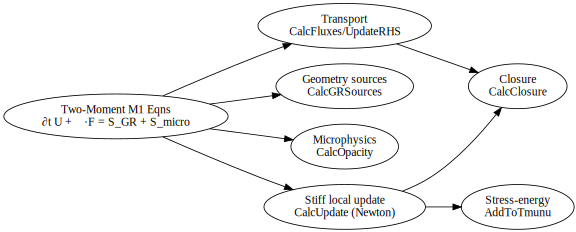

In [5]:
# Optional diagram: Physics ↔ Code mapping
mapdot = Digraph(comment="Physics to Code")
mapdot.attr(rankdir="LR", size="8")

mapdot.node("Eq", "Two-Moment M1 Eqns\n∂t U + ∇·F = S_GR + S_micro")
mapdot.node("Flux", "Transport\nCalcFluxes/UpdateRHS")
mapdot.node("GR", "Geometry sources\nCalcGRSources")
mapdot.node("Micro", "Microphysics\nCalcOpacity")
mapdot.node("Stiff", "Stiff local update\nCalcUpdate (Newton)")
mapdot.node("Closure", "Closure\nCalcClosure")
mapdot.node("Tmunu", "Stress-energy\nAddToTmunu")

mapdot.edges([("Eq","Flux"), ("Eq","GR"), ("Eq","Micro"), ("Eq","Stiff")])
mapdot.edge("Flux","Closure")
mapdot.edge("Stiff","Closure")
mapdot.edge("Stiff","Tmunu")

mapdot
